In [1]:
import os
import io
import sys
import re
import time
import math
import pickle

import numpy as np
import pandas as pd

from numpy import nan as Nan
from numpy import inf as inf
from tqdm import notebook as tqdm
from scipy.sparse import csr_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm



In [2]:
from data_preprocessing import *

In [3]:
path0 = 'groups_and_oxi_states/df_features_step_0.pkl'
path1 = 'groups_and_oxi_states/df_features_step_1.pkl'
path2 = 'groups_and_oxi_states/df_features_step_2.pkl'
path3 = 'groups_and_oxi_states/df_features_step_3.pkl'
path4 = 'groups_and_oxi_states/df_features_step_4.pkl'

df_0 = load_csv(path0)
df_1 = load_csv(path1)
df_2 = load_csv(path2)
df_3 = load_csv(path3)
df_4 = load_csv(path4)

dfs = [df_0, df_1, df_2, df_3, df_4]

In [4]:
grand_zero_columns = set()
nan_features = ['feature_9', 'feature_4', 'feature_16', 'feature_6']
for i, df in enumerate(dfs):
    dfs[i] = dfs[i].drop(['stru_traj', 'structure_A', 'structure_AM',
       'structure_CAN', 'structure_CAMN', 'structure_A40', 'structure_AM40',
       'structure_CAN40', 'structure_CAMN40'], axis = 1)
    dfs[i] = dfs[i].drop(nan_features, axis = 1)
    dfs[i], zero_columns = make_plane(dfs[i])
    grand_zero_columns.update(zero_columns)

In [5]:
for i, df in enumerate(dfs):
    dfs[i] = dfs[i].drop(grand_zero_columns, axis = 1)
    dfs[i] = dfs[i][dfs[i]['group'] != 'group_D']
    dfs[i]['is_good'] = (dfs[i]['group'] == 'group_A') | (dfs[i]['group'] == 'group_B') | (dfs[i]['group'] == 'group_E')
    dfs[i] = dfs[i].drop(['group'], axis = 1)


In [7]:
dfs[0]['stru_label'].to_list() == dfs[1]['stru_label'].to_list() == dfs[2]['stru_label'].to_list() == dfs[3]['stru_label'].to_list() == dfs[4]['stru_label'].to_list()

True

In [ ]:
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
scaler = StandardScaler()

for random_split in splits:
    assembled_pred = np.zeros(46)
    for df in dfs:
        grand_X = list()
        grand_y = list()
        X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
        X_scaled = scaler.fit_transform(X)
        grand_X.append(X_scaled)
        y = y.astype(int)
        grand_y.append(y)
        X_tr = list()
        y_tr = list()
        X_te = list()
        y_te = list()
        for X_scaled, y in zip(grand_X, grand_y):
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
            X_tr.extend(X_train)
            X_te.extend(X_test)
            y_tr.extend(y_train)
            y_te.extend(y_test)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=20,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True)
        y_pred = model.predict_proba(X_te)[:, 1]
        assembled_pred += y_pred
        print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
        indexes = np.argsort(model.predict_proba(X_te)[:, 1])
        break
    # assembled_pred /= len(dfs)
    roc_auc.append(roc_auc_score(y_te, assembled_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.8825757575757576
roc auc score 0.8825757575757576 for random_split 8334788


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.8038461538461539
roc auc score 0.8038461538461539 for random_split 9151291


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.9412878787878788
roc auc score 0.9412878787878788 for random_split 4517925


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.9288461538461539
roc auc score 0.9288461538461539 for random_split 5765657


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.9142300194931774
roc auc score 0.9142300194931774 for random_split 1797675
mean roc auc 0.8941571927098243


In [ ]:
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    for df in dfs:
        grand_X = list()
        grand_y = list()
        X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
        X_scaled = scaler.fit_transform(X)
        grand_X.append(X_scaled)
        y = y.astype(int)
        grand_y.append(y)
        X_tr = list()
        y_tr = list()
        X_te = list()
        y_te = list()
        for X_scaled, y in zip(grand_X, grand_y):
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
            X_tr.extend(X_train)
            X_te.extend(X_test)
            y_tr.extend(y_train)
            y_te.extend(y_test)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        assembled_pred += y_pred
        print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
        indexes = np.argsort(model.predict_proba(X_te)[:, 1])
        break
    # assembled_pred /= len(dfs)
    roc_auc.append(roc_auc_score(y_te, assembled_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

roc auc score 0.9034090909090908
roc auc score 0.9034090909090908 for random_split 8334788
roc auc score 0.8076923076923077
roc auc score 0.8076923076923077 for random_split 9151291
roc auc score 0.8570075757575758
roc auc score 0.8570075757575758 for random_split 4517925
roc auc score 0.8730769230769231
roc auc score 0.8730769230769231 for random_split 5765657
roc auc score 0.8304093567251463
roc auc score 0.8304093567251463 for random_split 1797675
mean roc auc 0.8543190508322087


In [ ]:
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    for df in dfs:
        grand_X = list()
        grand_y = list()
        X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
        X_scaled = scaler.fit_transform(X)
        grand_X.append(X_scaled)
        y = y.astype(int)
        grand_y.append(y)
        X_tr = list()
        y_tr = list()
        X_te = list()
        y_te = list()
        for X_scaled, y in zip(grand_X, grand_y):
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
            X_tr.extend(X_train)
            X_te.extend(X_test)
            y_tr.extend(y_train)
            y_te.extend(y_test)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=20,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        assembled_pred += y_pred
        print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
        indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    assembled_pred /= len(dfs)
    roc_auc.append(roc_auc_score(y_te, assembled_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

roc auc score 0.8825757575757576
roc auc score 0.9015151515151515
roc auc score 0.9166666666666666
roc auc score 0.9431818181818181
roc auc score 0.9071969696969697
roc auc score 0.9318181818181819 for random_split 8334788
roc auc score 0.8038461538461539
roc auc score 0.823076923076923
roc auc score 0.9
roc auc score 0.8576923076923078
roc auc score 0.8730769230769231
roc auc score 0.8692307692307693 for random_split 9151291
roc auc score 0.9412878787878788
roc auc score 0.928030303030303
roc auc score 0.8674242424242424
roc auc score 0.8920454545454546
roc auc score 0.8920454545454546
roc auc score 0.9261363636363635 for random_split 4517925
roc auc score 0.9288461538461539
roc auc score 0.6673076923076924
roc auc score 0.8173076923076923
roc auc score 0.8769230769230769
roc auc score 0.8884615384615385
roc auc score 0.823076923076923 for random_split 5765657
roc auc score 0.9142300194931774
roc auc score 0.949317738791423
roc auc score 0.9083820662768031
roc auc score 0.951267056530

In [ ]:
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    for df in dfs:
        grand_X = list()
        grand_y = list()
        X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
        X_scaled = scaler.fit_transform(X)
        grand_X.append(X_scaled)
        y = y.astype(int)
        grand_y.append(y)
        X_tr = list()
        y_tr = list()
        X_te = list()
        y_te = list()
        for X_scaled, y in zip(grand_X, grand_y):
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
            X_tr.extend(X_train)
            X_te.extend(X_test)
            y_tr.extend(y_train)
            y_te.extend(y_test)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        assembled_pred += y_pred
        print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
        indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    assembled_pred /= len(dfs)
    roc_auc.append(roc_auc_score(y_te, assembled_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

roc auc score 0.9034090909090908
roc auc score 0.8939393939393939
roc auc score 0.9034090909090908
roc auc score 0.9109848484848486
roc auc score 0.8996212121212122
roc auc score 0.9242424242424242 for random_split 8334788
roc auc score 0.8076923076923077
roc auc score 0.8153846153846154
roc auc score 0.8461538461538461
roc auc score 0.8576923076923078
roc auc score 0.6749999999999999
roc auc score 0.8403846153846154 for random_split 9151291
roc auc score 0.8570075757575758
roc auc score 0.9166666666666666
roc auc score 0.7443181818181818
roc auc score 0.9034090909090909
roc auc score 0.8257575757575757
roc auc score 0.9090909090909092 for random_split 4517925
roc auc score 0.8730769230769231
roc auc score 0.8865384615384615
roc auc score 0.675
roc auc score 0.6557692307692308
roc auc score 0.8807692307692307
roc auc score 0.8365384615384616 for random_split 5765657
roc auc score 0.8304093567251463
roc auc score 0.9512670565302143
roc auc score 0.9473684210526315
roc auc score 0.945419

In [18]:
def feature_preprocessing(dfs, include_trajectories = False):
    grand_X = list()
    grand_y = list()
    for df in dfs:
        scaler = StandardScaler()
        X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
        X_scaled = scaler.fit_transform(X)
        grand_X.append(X_scaled)
        y = y.astype(int)
        grand_y.append(y)
        if not include_trajectories:
            break
    return grand_X, grand_y

def get_train_test(grand_X, grand_y, random_split):
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)
    return X_tr, X_te, y_tr, y_te

In [20]:
def hyperparameters_of_select_features(num_features, steps):
    grand_X, grand_y = feature_preprocessing(dfs, True)

    roc_auc = []
    splits = [8334788, 9151291, 4517925, 5765657, 1797675]


    for random_split in splits:
        assembled_pred = np.zeros(46)
        for X_scaled, y in zip(grand_X, grand_y):
            X_te = list()
            y_te = list()
            X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
            model = CatBoostClassifier(eval_metric='AUC', verbose = False)
            feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
            test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
            summary = model.select_features(
            X = X_tr,
            y=y_tr,
            eval_set=test_pool,
            features_for_select= np.arange(len(X_tr[0])),
            num_features_to_select=num_features,
            steps=steps,
            algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=True,
            logging_level='Silent',
            plot=False)
            y_pred = model.predict_proba(X_te)[:, 1]
            print(roc_auc_score(y_te, y_pred), random_split)
            assembled_pred += y_pred
        assembled_pred /= len(dfs)
        print(f"roc auc score {roc_auc_score(y_te, assembled_pred)} for random split {random_split}")
        roc_auc.append(roc_auc_score(y_te, assembled_pred))
    print(f"mean roc auc score {np.mean(roc_auc)}")

num_features_to_select=80, steps=6 for all trajectories

In [21]:
hyperparameters_of_select_features(num_features = 80, steps = 6)

0.9053030303030303 8334788
0.8920454545454545 8334788
0.9034090909090909 8334788
0.9299242424242424 8334788
0.9109848484848485 8334788
roc auc score 0.912878787878788 for random split 8334788
0.9115384615384614 9151291
0.7192307692307692 9151291
0.8288461538461539 9151291
0.8326923076923076 9151291
0.9115384615384616 9151291
roc auc score 0.8634615384615384 for random split 9151291
0.6704545454545454 4517925
0.8901515151515151 4517925
0.9261363636363636 4517925
0.8806818181818182 4517925
0.8484848484848485 4517925
roc auc score 0.9109848484848485 for random split 4517925
0.8365384615384615 5765657
0.8038461538461539 5765657
0.7923076923076923 5765657
0.926923076923077 5765657
0.9384615384615385 5765657
roc auc score 0.9384615384615385 for random split 5765657
0.9220272904483431 1797675
0.9415204678362573 1797675
0.9668615984405458 1797675
0.9688109161793372 1797675
0.949317738791423 1797675
roc auc score 0.962962962962963 for random split 1797675
mean roc auc score 0.9177499352499352


In [19]:
grand_X, grand_y = feature_preprocessing(dfs, True)

roc_auc = []
splits = [8334788, 9151291, 4517925, 5765657, 1797675]


for random_split in splits:
    assembled_pred = np.zeros(46)
    for X_scaled, y in zip(grand_X, grand_y):
        X_te = list()
        y_te = list()
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=80,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        print(roc_auc_score(y_te, y_pred), random_split)
        assembled_pred += y_pred
    assembled_pred /= len(dfs)
    print(f"roc auc score {roc_auc_score(y_te, assembled_pred)} for random split {random_split}")
    roc_auc.append(roc_auc_score(y_te, assembled_pred))
print(f"mean roc auc score {np.mean(roc_auc)}")

0.9053030303030303 8334788
0.9115384615384614 9151291


KeyboardInterrupt: 

In [ ]:
grand_X, grand_y = feature_preprocessing(dfs, True)

roc_auc = []
splits = [8334788, 9151291, 4517925, 5765657, 1797675]


for random_split in splits:
    assembled_pred = np.zeros(46)
    for X_scaled, y in zip(grand_X, grand_y):
        X_te = list()
        y_te = list()
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        print(roc_auc_score(y_te, y_pred), random_split)
        assembled_pred += y_pred
        break
    # assembled_pred /= len(dfs)
    # print(f"roc auc score {roc_auc_score(y_te, assembled_pred)} for random split {random_split}")
    # roc_auc.append(roc_auc_score(y_te, assembled_pred))
print(f"mean roc auc score {np.mean(roc_auc)}")

0.9034090909090908 8334788
0.8076923076923077 9151291
0.8570075757575758 4517925
0.8730769230769231 5765657
0.8304093567251463 1797675


In [ ]:
grand_X, grand_y = feature_preprocessing(dfs, True)

roc_auc = []
splits = [8334788, 9151291, 4517925, 5765657, 1797675]


for random_split in splits:
    assembled_pred = np.zeros(46)
    for X_scaled, y in zip(grand_X, grand_y):
        X_te = list()
        y_te = list()
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=80,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        print(roc_auc_score(y_te, y_pred), random_split)
        assembled_pred += y_pred
        break
    # assembled_pred /= len(dfs)
    # print(f"roc auc score {roc_auc_score(y_te, assembled_pred)} for random split {random_split}")
    # roc_auc.append(roc_auc_score(y_te, assembled_pred))
# print(f"mean roc auc score {np.mean(roc_auc)}")

0.8219696969696969 8334788
0.8480769230769231 9151291
0.5814393939393939 4517925


In [ ]:
grand_X, grand_y = feature_preprocessing(dfs, True)

roc_auc = []
splits = [8334788, 9151291, 4517925, 5765657, 1797675]


for random_split in splits:
    assembled_pred = np.zeros(46)
    for X_scaled, y in zip(grand_X, grand_y):
        X_te = list()
        y_te = list()
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=17,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        print(roc_auc_score(y_te, y_pred), random_split)
        assembled_pred += y_pred
        break
    # assembled_pred /= len(dfs)
    # print(f"roc auc score {roc_auc_score(y_te, assembled_pred)} for random split {random_split}")
    # roc_auc.append(roc_auc_score(y_te, assembled_pred))
# print(f"mean roc auc score {np.mean(roc_auc)}")

0.8958333333333334 8334788
0.8403846153846153 9151291


KeyboardInterrupt: 

In [ ]:
colors = ['lightgreen' if v == 1 else 'pink' for v in y_tr]

assembled_pred = np.zeros(46)

for df in dfs:
    grand_X = list()
    grand_y = list()
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=45)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True)
    y_pred = model.predict_proba(X_te)[:, 1]
    assembled_pred += y_pred
    # print(np.argsort(model.get_feature_importance())[::-1][:2])
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
    break
    indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    print(np.array(y_te)[indexes.astype(int)])

    features = np.array(X_tr)[:, [484, 189]]
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    # plt.legend()
    # plt.show()
#     print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
#     roc_auc.append(roc_auc_score(y_te, y_pred))
# print(f"mean roc auc score: {np.mean(roc_auc)}")
assembled_pred /= len(dfs)
print(assembled_pred)
print(f"roc auc score {roc_auc_score(y_te, assembled_pred)}")

69 46


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.8903846153846153
[0.0358462  0.01432711 0.10349164 0.01917713 0.00761673 0.00683753
 0.15864977 0.05583859 0.12302941 0.00573038 0.13803172 0.12830251
 0.0071702  0.09974363 0.15179781 0.04377561 0.0069046  0.02381497
 0.14126722 0.18683784 0.13858803 0.13936764 0.05859443 0.00222912
 0.17266015 0.15571679 0.14040094 0.12575666 0.15074288 0.08413388
 0.15372241 0.0258775  0.03953465 0.06569359 0.00539475 0.04179507
 0.09715708 0.10505127 0.0054884  0.00262805 0.06395666 0.03434742
 0.07204907 0.09970842 0.02819749 0.1630626 ]
roc auc score 0.8903846153846153


In [ ]:
colors = ['lightgreen' if v == 1 else 'pink' for v in y_tr]

assembled_pred = np.zeros(46)

for df in dfs:
    grand_X = list()
    grand_y = list()
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=45)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False, random_state = 0)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=90,
    steps=6,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True)
    y_pred = model.predict_proba(X_te)[:, 1]
    assembled_pred += y_pred
    # print(np.argsort(model.get_feature_importance())[::-1][:2])
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
    break
    indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    print(np.array(y_te)[indexes.astype(int)])

    features = np.array(X_tr)[:, [484, 189]]
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    # plt.legend()
    # plt.show()
#     print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
#     roc_auc.append(roc_auc_score(y_te, y_pred))
# print(f"mean roc auc score: {np.mean(roc_auc)}")
assembled_pred /= len(dfs)
print(assembled_pred)
print(f"roc auc score {roc_auc_score(y_te, assembled_pred)}")

69 46


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.9134615384615384
[0.05236154 0.0566806  0.12014073 0.01103757 0.01371812 0.01931749
 0.16266578 0.02998267 0.09216728 0.02764443 0.16579144 0.14871209
 0.00975589 0.13464574 0.12494082 0.05772702 0.03544522 0.06970152
 0.12024285 0.18021577 0.11874554 0.17429918 0.09396496 0.00851573
 0.18121122 0.14602287 0.13510033 0.1402803  0.12383236 0.06762533
 0.13919044 0.03102073 0.02421192 0.09528401 0.01599118 0.03782916
 0.09423272 0.07933168 0.02375034 0.01005116 0.08700318 0.02874307
 0.09290132 0.08951558 0.0497804  0.14115605]
roc auc score 0.9134615384615384


In [ ]:
colors = ['lightgreen' if v == 1 else 'pink' for v in y_tr]

assembled_pred = np.zeros(46)

for df in dfs:
    grand_X = list()
    grand_y = list()
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=45)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False, random_state = 0)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=17,
    steps=6,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True)
    y_pred = model.predict_proba(X_te)[:, 1]
    assembled_pred += y_pred
    # print(np.argsort(model.get_feature_importance())[::-1][:2])
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
    break
    indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    print(np.array(y_te)[indexes.astype(int)])

    features = np.array(X_tr)[:, [484, 189]]
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    # plt.legend()
    # plt.show()
#     print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
#     roc_auc.append(roc_auc_score(y_te, y_pred))
# print(f"mean roc auc score: {np.mean(roc_auc)}")
assembled_pred /= len(dfs)
print(assembled_pred)
print(f"roc auc score {roc_auc_score(y_te, assembled_pred)}")

69 46


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

roc auc score 0.926923076923077
[0.02679476 0.01707507 0.08009298 0.00514895 0.00286532 0.00540397
 0.16851489 0.00503816 0.08946981 0.00512066 0.18192509 0.15802736
 0.00187746 0.13249954 0.08636405 0.09141792 0.0049212  0.02992647
 0.16020871 0.18822161 0.04343524 0.18726149 0.13057852 0.00172507
 0.18784091 0.19595821 0.1601188  0.13774243 0.05258335 0.03412332
 0.13888745 0.03256482 0.03799103 0.04581204 0.00434208 0.02270436
 0.16420154 0.04585406 0.00766099 0.00296335 0.11972927 0.01289262
 0.15470288 0.01715529 0.03637721 0.19368478]
roc auc score 0.926923076923077


667 - 577 = 90

In [ ]:
X_tr = np.array(X_tr)
X_tr.shape

(69, 667)

69 46
roc auc score 0.8903846153846153
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1]
69 46
roc auc score 0.9115384615384615
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1]
69 46
roc auc score 0.8846153846153846
[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1]
69 46
roc auc score 0.8423076923076922
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1]
69 46
roc auc score 0.9057692307692308
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1]
[0.35502539 0.31663603 0.5195849  0.14817885 0.10606221 0.10956529
 0.75035025 0.29043156 0.42024861 0.25337889 0.77712046 0.55059405
 0.11708523 0.47929533 0.4723457  0.18634234 0.12778087 0.26103816
 0.6403313  0.8491487  0.64045683 0.80202595 0.57445133 0.09611733
 0.75830973 0.8136371  0.64965531 0.73214577 0.57591979 0.4377

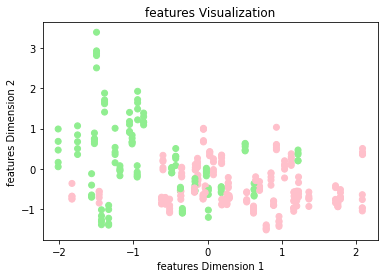

In [ ]:
colors = ['lightgreen' if v == 1 else 'pink' for v in y_tr]

assembled_pred = np.zeros(46)

for df in dfs:
    grand_X = list()
    grand_y = list()
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=45)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    assembled_pred += y_pred
    # print(np.argsort(model.get_feature_importance())[::-1][:2])
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
    indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    print(np.array(y_te)[indexes.astype(int)])

    features = np.array(X_tr)[:, [484, 189]]
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    # plt.legend()
    # plt.show()
#     print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
#     roc_auc.append(roc_auc_score(y_te, y_pred))
# print(f"mean roc auc score: {np.mean(roc_auc)}")
assembled_pred /= len(dfs)
print(assembled_pred)
print(f"roc auc score {roc_auc_score(y_te, assembled_pred)}")

69 46
roc auc score 0.8903846153846153
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1]
69 46
roc auc score 0.9115384615384615
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1]
69 46
roc auc score 0.8846153846153846
[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1]
69 46
roc auc score 0.8423076923076922
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1]
69 46
roc auc score 0.9057692307692308
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1]
[0.35502539 0.31663603 0.5195849  0.14817885 0.10606221 0.10956529
 0.75035025 0.29043156 0.42024861 0.25337889 0.77712046 0.55059405
 0.11708523 0.47929533 0.4723457  0.18634234 0.12778087 0.26103816
 0.6403313  0.8491487  0.64045683 0.80202595 0.57445133 0.09611733
 0.75830973 0.8136371  0.64965531 0.73214577 0.57591979 0.4377

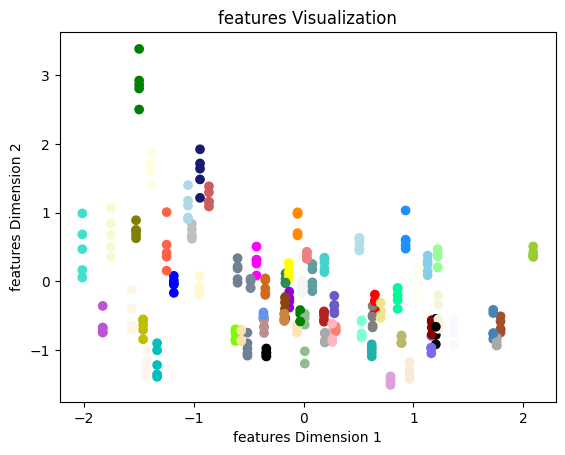

In [ ]:
colors = ['lightgreen' if v == 1 else 'pink' for v in y_tr]

assembled_pred = np.zeros(46)

for df, color in zip(dfs, colors):
    grand_X = list()
    grand_y = list()
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=45)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select= np.arange(len(X_tr)),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    assembled_pred += y_pred
    # print(np.argsort(model.get_feature_importance())[::-1][:2])
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
    indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    print(np.array(y_te)[indexes.astype(int)])

    features = np.array(X_tr)[:, [484, 189]]
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    # plt.legend()
    # plt.show()
#     print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
#     roc_auc.append(roc_auc_score(y_te, y_pred))
# print(f"mean roc auc score: {np.mean(roc_auc)}")
assembled_pred /= len(dfs)
print(assembled_pred)
print(f"roc auc score {roc_auc_score(y_te, assembled_pred)}")

69 46
roc auc score 0.8903846153846153
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1]
69 46
roc auc score 0.9115384615384615
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1]
69 46
roc auc score 0.8846153846153846
[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1]
69 46
roc auc score 0.8423076923076922
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1]
69 46
roc auc score 0.9057692307692308
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1]
[0.35502539 0.31663603 0.5195849  0.14817885 0.10606221 0.10956529
 0.75035025 0.29043156 0.42024861 0.25337889 0.77712046 0.55059405
 0.11708523 0.47929533 0.4723457  0.18634234 0.12778087 0.26103816
 0.6403313  0.8491487  0.64045683 0.80202595 0.57445133 0.09611733
 0.75830973 0.8136371  0.64965531 0.73214577 0.57591979 0.4377

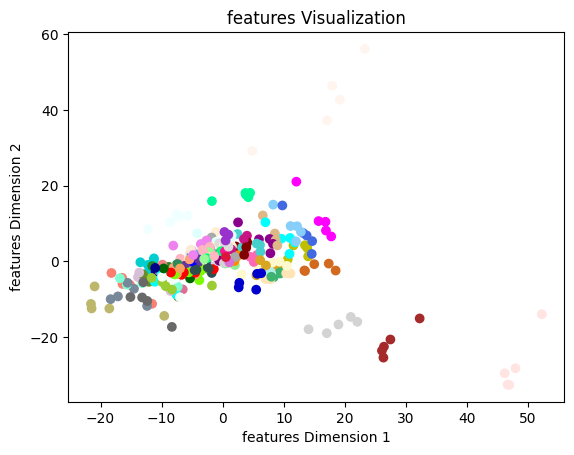

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import random
scaler = StandardScaler()

catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=False)
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from random import shuffle
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = list(colors.keys())
shuffle(colors)
colors = colors[:69]
assembled_pred = np.zeros(46)

for df, color in zip(dfs, colors):
    grand_X = list()
    grand_y = list()
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=45)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select= np.arange(len(X_tr[0])),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    assembled_pred += y_pred
    # print(np.argsort(model.get_feature_importance())[::-1][:2])
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
    indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    print(np.array(y_te)[indexes.astype(int)])
    pca = PCA(n_components=2)
    features = pca.fit_transform(X_tr)
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    # plt.legend()
    # plt.show()
#     print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
#     roc_auc.append(roc_auc_score(y_te, y_pred))
# print(f"mean roc auc score: {np.mean(roc_auc)}")
assembled_pred /= len(dfs)
print(assembled_pred)
print(f"roc auc score {roc_auc_score(y_te, assembled_pred)}")

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import random
scaler = StandardScaler()

catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

grand_X = list()
grand_y = list()
for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)

roc_auc = []

splits = [45]
for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
    roc_auc.append(roc_auc_score(y_te, y_pred))
print(f"mean roc auc score: {np.mean(roc_auc)}")

345 230
roc auc score 0.8845384615384616, for random split 45
mean roc auc score: 0.8845384615384616


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import random
scaler = StandardScaler()

catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

grand_X = list()
grand_y = list()
for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)

roc_auc = []

splits = [45]
for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
    roc_auc.append(roc_auc_score(y_te, y_pred))
print(f"mean roc auc score: {np.mean(roc_auc)}")

345 230
roc auc score 0.8845384615384616, for random split 45
mean roc auc score: 0.8845384615384616


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

grand_X = list()
grand_y = list()
scaler = StandardScaler()

for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    break

splits = [45]
for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))

69 46


In [ ]:
from metric_learn import NCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

nca = NCA(max_iter=1000)
nca.fit(X_tr, y_tr)
knn = KNeighborsClassifier(metric=nca.get_metric())
knn.fit(X_tr, y_tr)
y_pred = knn.predict_proba(X_te)[:, 1]
print(f"roc auc score {roc_auc_score(y_te, y_pred)}")

nca = NCA(max_iter=1000)
nca.fit(X_tr, y_tr)
knn = KNeighborsClassifier()
knn.fit(X_tr, y_tr)
y_pred = knn.predict_proba(X_te)[:, 1]
print(f"roc auc score {roc_auc_score(y_te, y_pred)}")


roc auc score 0.6211538461538462
roc auc score 0.596153846153846


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

grand_X = list()
grand_y = list()
scaler = StandardScaler()

for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)
    
splits = [45]
for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))

from metric_learn import NCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

nca = NCA(max_iter=1000)
nca.fit(X_tr, y_tr)
knn = KNeighborsClassifier(metric=nca.get_metric())
knn.fit(X_tr, y_tr)
y_pred = knn.predict_proba(X_te)[:, 1]
print(f"roc auc score {roc_auc_score(y_te, y_pred)}")

nca = NCA(max_iter=1000)
nca.fit(X_tr, y_tr)
knn = KNeighborsClassifier()
knn.fit(X_tr, y_tr)
y_pred = knn.predict_proba(X_te)[:, 1]
print(f"roc auc score {roc_auc_score(y_te, y_pred)}")


345 230
roc auc score 0.7171538461538461
roc auc score 0.7171538461538461


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from metric_learn import SDML_Supervised
from sklearn.preprocessing import StandardScaler

import random
scaler = StandardScaler()

catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

grand_X = list()
grand_y = list()
for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X_scaled)
    y = y.astype(int)
    grand_y.append(y)

roc_auc = []

splits = [45]
for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_tr.extend(X_train)
        X_te.extend(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
    print(len(X_tr), len(X_te))
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select=np.arange(len(X_tr[0])),
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
    roc_auc.append(roc_auc_score(y_te, y_pred))
print(f"mean roc auc score: {np.mean(roc_auc)}")

ModuleNotFoundError: No module named 'catboost'

In [ ]:
y_pred = model.predict_proba(X_te)[:, 1]
print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")

roc auc score 0.8460038986354775, for random split 1797675


In [ ]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import random
scaler = StandardScaler()

catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

grand_X = list()
grand_y = list()
for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X.to_numpy())
    y = y.astype(int)
    grand_y.append(y)
    break

roc_auc = []

X_tr = list()
y_tr = list()
X_te = list()
y_te = list()
for X_scaled, y in zip(grand_X, grand_y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
    X_tr.extend(X_train)
    X_te.extend(X_test)
    y_tr.extend(y_train)
    y_te.extend(y_test)
print(len(X_tr), len(X_te))


69 46


In [ ]:
y_pred = model.predict_proba(X_te)[:, 1]
print(f"roc auc score {roc_auc_score(y_te, y_pred)}")

roc auc score 0.8519269776876267


In [ ]:
splits = [8334788, 9151291, 4517925, 5765657, 1797675]

for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
        X_tr.extend(X_train[:, summary['selected_features']])
        X_te.extend(X_test[:, summary['selected_features']])
    best_model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    best_model.fit(X_tr, y_tr)
    y_pred = best_model.predict_proba(X_te)[:, 1]
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
    roc_auc.append(roc_auc_score(y_te, y_pred))
print(f"mean roc auc score: {np.mean(roc_auc)}")

roc auc score 0.8049242424242424, for random split 8334788
roc auc score 0.775, for random split 9151291
roc auc score 0.8030303030303031, for random split 4517925
roc auc score 0.7865384615384616, for random split 5765657
roc auc score 0.8265107212475633, for random split 1797675
mean roc auc score: 0.799200745648114


In [ ]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import random
scaler = StandardScaler()

catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

grand_X = list()
grand_y = list()
for df in dfs:
    X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
    X_scaled = scaler.fit_transform(X)
    grand_X.append(X.to_numpy())
    y = y.astype(int)
    grand_y.append(y)
    
roc_auc = []

X_tr = list()
y_tr = list()
X_te = list()
y_te = list()
for X_scaled, y in zip(grand_X, grand_y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
    X_tr.extend(X_train)
    X_te.extend(X_test)
    y_tr.extend(y_train)
    y_te.extend(y_test)
print(len(X_tr), len(X_te))

feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
train_pool = Pool(np.array(X_tr), y_tr, feature_names=feature_names)
test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)

model = CatBoostClassifier(eval_metric='AUC', verbose=False)
summary = model.select_features(
    X = X_tr,
    y=y_tr,
    eval_set=test_pool,
    features_for_select='0-666',
    num_features_to_select=50,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

345 230


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
splits = [8334788, 9151291, 4517925, 5765657, 1797675]

for random_split in splits:
    X_tr = list()
    y_tr = list()
    X_te = list()
    y_te = list()
    for X_scaled, y in zip(grand_X, grand_y):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_tr.extend(y_train)
        y_te.extend(y_test)
        X_tr.extend(X_train[:, summary['selected_features']])
        X_te.extend(X_test[:, summary['selected_features']])
    best_model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    best_model.fit(X_tr, y_tr)
    y_pred = best_model.predict_proba(X_te)[:, 1]
    print(f"roc auc score {roc_auc_score(y_te, y_pred)}, for random split {random_split}")
    roc_auc.append(roc_auc_score(y_te, y_pred))
print(f"mean roc auc score: {np.mean(roc_auc)}")

roc auc score 0.8411363636363637, for random split 8334788
roc auc score 0.7440769230769231, for random split 9151291
roc auc score 0.7775, for random split 4517925
roc auc score 0.7828461538461537, for random split 5765657
roc auc score 0.8251851851851851, for random split 1797675
mean roc auc score: 0.7941489251489251


In [ ]:
import matplotlib.pyplot as plt

plt.subplot(326)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(pca.singular_values_[:, 0], pca.singular_values_[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.show()

roc auc score 0.9034090909090908
roc auc score 0.8939393939393939
roc auc score 0.9034090909090908
roc auc score 0.9109848484848486
roc auc score 0.8996212121212122


ValueError: 'c' argument has 46 elements, which is inconsistent with 'x' and 'y' with size 69.

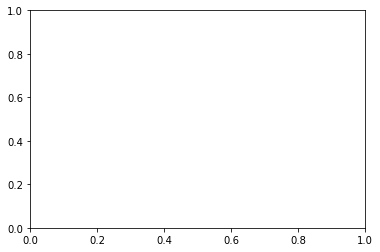

In [ ]:
splits = [8334788]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    for i, df in enumerate(dfs):
        grand_X = list()
        grand_y = list()
        X, y = (df.drop(['is_good', 'stru_label'], axis=1), df['is_good'])
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        grand_X.append(X_scaled)
        y = y.astype(int)
        grand_y.append(y)
        X_tr = list()
        y_tr = list()
        X_te = list()
        y_te = list()
        for X_scaled, y in zip(grand_X, grand_y):
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
            X_tr.extend(X_train)
            X_te.extend(X_test)
            y_tr.extend(y_train)
            y_te.extend(y_test)
        model = CatBoostClassifier(eval_metric='AUC', verbose = False)
        feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
        test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
        summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
        y_pred = model.predict_proba(X_te)[:, 1]
        assembled_pred += y_pred
        print(f"roc auc score {roc_auc_score(y_te, y_pred)}")
        indexes = np.argsort(model.predict_proba(X_te)[:, 1])
    assembled_pred /= len(dfs)

    pca = PCA(n_components=2)
    features = pca.fit_transform(X_te)
    colors = ['r' if v >= 0.5 else 'b' for v in assembled_pred]
    plt.scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
    plt.xlabel('features Dimension 1')
    plt.ylabel('features Dimension 2')
    plt.title('features Visualization')
    roc_auc.append(roc_auc_score(y_te, assembled_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

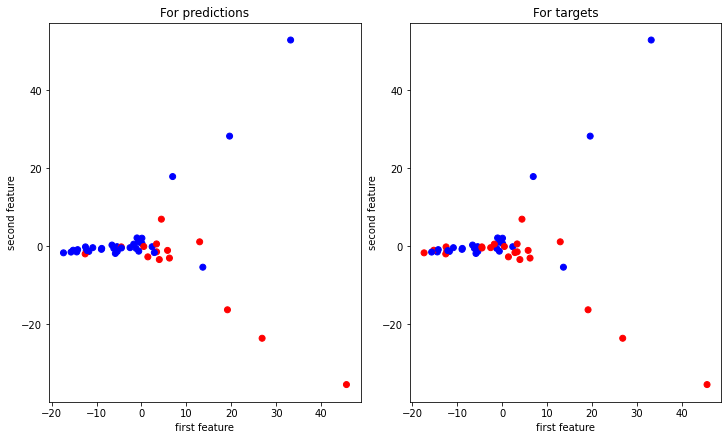

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 6),
                        layout="constrained")

pca = PCA(n_components=2)
features = pca.fit_transform(X_te)
colors = ['r' if v >= 0.5 else 'b' for v in assembled_pred]

axes[0].scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
axes[0].set_xlabel('first feature')
axes[0].set_ylabel('second feature')
axes[0].set_title('For predictions')

colors = ['r' if v == 1 else 'b' for v in y_te]
axes[1].scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
axes[1].set_xlabel('first feature')
axes[1].set_ylabel('second feature')
axes[1].set_title('For targets');

In [ ]:
model.get_feature_importance()[484]

11.958954984461153

In [ ]:
indexes = np.argsort(model.get_feature_importance())[::-1]

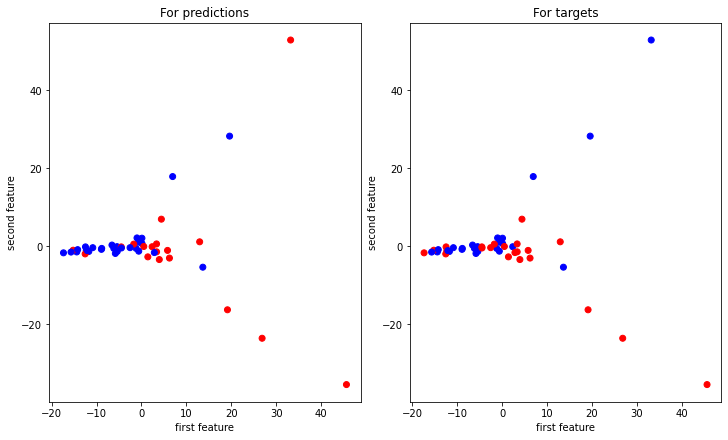

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 6),
                        layout="constrained")

pca = PCA(n_components=2)
features = pca.fit_transform(X_te)
colors = ['r' if v >= 0.4 else 'b' for v in assembled_pred]

axes[0].scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
axes[0].set_xlabel('first feature')
axes[0].set_ylabel('second feature')
axes[0].set_title('For predictions')

colors = ['r' if v == 1 else 'b' for v in y_te]
axes[1].scatter(features[:, 0], features[:, 1], c=colors, marker='o', label='Data Points')
axes[1].set_xlabel('first feature')
axes[1].set_ylabel('second feature')
axes[1].set_title('For targets');

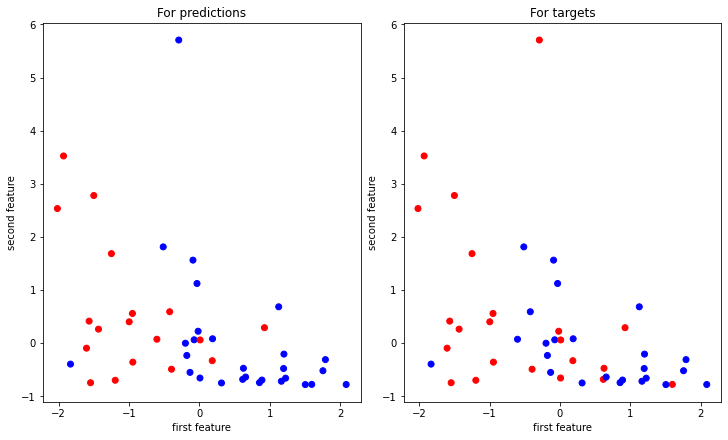

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 6),
                        layout="constrained")

colors = ['r' if v >= 0.4 else 'b' for v in assembled_pred]

X_te = np.array(X_te)
feature_0 = X_te[:, indexes[0]]
feature_1 = X_te[:, indexes[1]]
axes[0].scatter(feature_0, feature_1, c=colors, marker='o', label='Data Points')
axes[0].set_xlabel('first feature')
axes[0].set_ylabel('second feature')
axes[0].set_title('For predictions')

colors = ['r' if v == 1 else 'b' for v in y_te]
axes[1].scatter(feature_0, feature_1, c=colors, marker='o', label='Data Points')
axes[1].set_xlabel('first feature')
axes[1].set_ylabel('second feature')
axes[1].set_title('For targets');